In [1]:
import copy
import time
import dgl
from model import Model
from utils import *
from sklearn.metrics import roc_auc_score
from torch.utils.data.dataset import Dataset
import random
import os
import argparse
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.io as sio
import datetime
from ggd import GGD
from typing import List

Using backend: pytorch


In [2]:
class Args:
    def __init__(self):
        self.cuda = True
        
        self.dataset = "cora"
        self.device = "cuda:0"
        self.embedding_dim = 64
        
        self.n_ggd_epochs = 100
        self.patience = 500
        self.batch_size = 300
        
        self.n_hidden = 256
        self.n_layers = 1
        self.dropout = 0
        self.proj_layers = 1
        self.gnn_encoder = 'gcn'
        self.num_hop = 10
        self.ggd_lr = 1e-3
        self.weight_decay = 0.
        
        self.auc_test_rounds = 256
args =  Args()

def aug_feature_dropout(input_feat, drop_percent=0.2):
    # aug_input_feat = copy.deepcopy((input_feat.squeeze(0)))
    aug_input_feat = copy.deepcopy(input_feat)
    drop_feat_num = int(aug_input_feat.shape[1] * drop_percent)
    drop_idx = random.sample([i for i in range(aug_input_feat.shape[1])], drop_feat_num)
    aug_input_feat[:, drop_idx] = 0
    
    return aug_input_feat

In [3]:
print('Dataset: {}'.format(args.dataset), flush=True)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = args.batch_size

adj, features, labels, idx_train, idx_val, idx_test, ano_label, str_ano_label, attr_ano_label = load_mat(args.dataset)

features, _ = preprocess_features(features)
dgl_graph = adj_to_dgl_graph(adj)
src, dst = np.nonzero(adj)
g = dgl.graph((src, dst))
g.ndata['feat'] = torch.FloatTensor(features)
g.ndata['label'] = torch.LongTensor(labels)
n_edges = g.number_of_edges()

Dataset: cora


G:\GNN\Graph-Group-Discrimination-main\venv\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [4]:
nb_nodes = features.shape[0]
ft_size = features.shape[1]
nb_classes = labels.shape[1]

# adj = normalize_adj(adj)
# adj = (adj + sp.eye(adj.shape[0])).todense()
# adj = torch.FloatTensor(adj[np.newaxis]).to(device)

features = torch.FloatTensor(features).to(device)
labels = torch.FloatTensor(labels).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

Create GGD model

In [5]:
g = g.to(device)
# Create GGD model
ggd = GGD(g,
          ft_size,
          args.n_hidden,
          args.n_layers,
          nn.PReLU(args.n_hidden),
          args.dropout,
          args.proj_layers,
          args.gnn_encoder,
          args.num_hop)

if args.cuda:
    ggd.cuda()

ggd_optimizer = torch.optim.Adam(ggd.parameters(),
                                 lr=args.ggd_lr,
                                 weight_decay=args.weight_decay)
b_xent = nn.BCEWithLogitsLoss()

In [6]:


# train GGD
cnt_wait = 0
best = 1e9
best_t = 0
counts = 0
avg_time = 0
dur = []

tag = str(datetime.datetime.now().strftime("%m-%d %H%M%S"))
print("Memory beg:", torch.cuda.memory_allocated(device) / 1024 / 1024)

Memory beg: 16.54345703125


In [7]:
epoch_list = []
auc_score_list = []
auc_pos_list = []
auc_neg_list = []
pos_std = []
neg_std = []
score_std = []

for epoch in range(args.n_ggd_epochs):
    if epoch % 10 == 0:
        # Evaluation
        ggd.eval()
        with torch.no_grad():
            pos_prob_list = []
            neg_prob_list = []
            for i in range(args.auc_test_rounds):
                feature_dropout = aug_feature_dropout(features, 0.2)
                pos_prob_list.append(ggd.forward_predict(features, False).detach())
                neg_prob_list.append(ggd.forward_predict(features, True).detach())
            pos_prob = torch.mean(torch.stack(pos_prob_list), axis=0)
            neg_prob = torch.mean(torch.stack(neg_prob_list), axis=0)
            ano_score = (neg_prob - pos_prob).cpu().numpy()
            epoch_list.append(epoch)
            auc_score_list.append(roc_auc_score(ano_label, ano_score))
            auc_pos_list.append(roc_auc_score(ano_label, 1 - pos_prob.cpu().numpy()))
            auc_neg_list.append(roc_auc_score(ano_label, neg_prob.cpu().numpy()))
            pos_std.append(np.std(pos_prob.cpu().numpy()))
            neg_std.append(np.std(neg_prob.cpu().numpy()))
            score_std.append(np.std(ano_score))
    t0 = time.time()
    ggd.train()
    if epoch >= 3:
        t0 = time.time()
    ggd_optimizer.zero_grad()
    lbl_1 = torch.zeros(1, g.number_of_nodes())
    lbl_2 = torch.ones(1, g.number_of_nodes())
    lbl = torch.cat((lbl_1, lbl_2), 1).cuda()
    # import pdb; pdb.set_trace()
    aug_feat = aug_feature_dropout(features, 0.2)
    loss = ggd(aug_feat.cuda(), lbl, b_xent)
    loss.backward()
    ggd_optimizer.step()

    comp_time = time.time() - t0
    # print('{} seconds'.format(comp_time))

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(ggd.state_dict(), 'checkpoints_ggd/best_ggd' + tag + '.pkl')
    else:
        cnt_wait += 1

    if cnt_wait == args.patience:
        print('Early stopping!')
        break

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Time(s) {:.4f} | Loss {:.4f} | "
          "ETputs(KTEPS) {:.2f}".format(epoch, np.mean(dur), loss.item(),
                                        n_edges / np.mean(dur) / 1000))

    avg_time += comp_time
    counts += 1

G:\GNN\Graph-Group-Discrimination-main\venv\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
G:\GNN\Graph-Group-Discrimination-main\venv\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Loss 0.6957 | ETputs(KTEPS) nan
Epoch 00001 | Time(s) nan | Loss 0.7040 | ETputs(KTEPS) nan
Epoch 00002 | Time(s) nan | Loss 0.6940 | ETputs(KTEPS) nan
Epoch 00003 | Time(s) 0.0100 | Loss 0.6925 | ETputs(KTEPS) 1159.52
Epoch 00004 | Time(s) 0.0080 | Loss 0.6964 | ETputs(KTEPS) 1449.39
Epoch 00005 | Time(s) 0.0073 | Loss 0.6945 | ETputs(KTEPS) 1581.16
Epoch 00006 | Time(s) 0.0080 | Loss 0.6913 | ETputs(KTEPS) 1449.43
Epoch 00007 | Time(s) 0.0082 | Loss 0.6898 | ETputs(KTEPS) 1414.08
Epoch 00008 | Time(s) 0.0078 | Loss 0.6916 | ETputs(KTEPS) 1480.27
Epoch 00009 | Time(s) 0.0077 | Loss 0.6913 | ETputs(KTEPS) 1503.12
Epoch 00010 | Time(s) 0.0080 | Loss 0.6892 | ETputs(KTEPS) 1449.43
Epoch 00011 | Time(s) 0.0082 | Loss 0.6876 | ETputs(KTEPS) 1410.26
Epoch 00012 | Time(s) 0.0084 | Loss 0.6869 | ETputs(KTEPS) 1384.86
Epoch 00013 | Time(s) 0.0083 | Loss 0.6877 | ETputs(KTEPS) 1405.81
Epoch 00014 | Time(s) 0.0083 | Loss 0.6843 | ETputs(KTEPS) 1395.22
Epoch 00015 | Ti

In [8]:
# epoch_list 
# auc_score_list 
# auc_pos_list 
# auc_neg_list 
# pos_std 
# neg_std 
# score_std 
print(epoch_list)
print(auc_score_list)
print(auc_pos_list)
print(auc_neg_list)
print(pos_std)
print(neg_std)
print(score_std)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
[0.5173195204586918, 0.46407740422204846, 0.44827078446703156, 0.4561858222569716, 0.5131000781860828, 0.5052215272348188, 0.5358887151420381, 0.5666340891321344, 0.4721540265832682, 0.515049517852489]
[0.5844930935626791, 0.3286473807662236, 0.29842194422726087, 0.31766093302058906, 0.3407961949439666, 0.3242832942402919, 0.32846624967422466, 0.3426048996611937, 0.3377808183476675, 0.3593393275996873]
[0.3014725045608548, 0.7042845973416731, 0.7371344800625488, 0.7449622100599426, 0.7463421944227261, 0.7459069585613762, 0.7436968986187125, 0.7426075058639562, 0.741922074537399, 0.740095126400834]
[0.007808814, 0.024083933, 0.05709623, 0.10699425, 0.12210294, 0.13816798, 0.13638526, 0.13757953, 0.17302518, 0.16165432]
[0.0024881244, 0.013983645, 0.029181061, 0.05482062, 0.07645066, 0.101491585, 0.1262833, 0.14927119, 0.14802688, 0.1625121]
[0.007468937, 0.019663367, 0.05203585, 0.10697826, 0.1330575, 0.15743369, 0.17357029, 0.19412987, 0.21821336

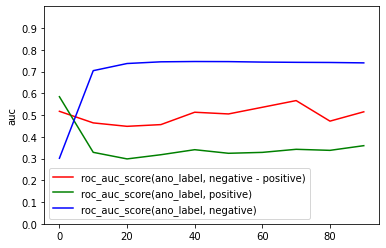

In [9]:
import matplotlib.pyplot as plt
plt.plot(epoch_list, auc_score_list, 'r', label="roc_auc_score(ano_label, negative - positive)")
plt.plot(epoch_list, auc_pos_list, 'g', label="roc_auc_score(ano_label, positive)")
plt.plot(epoch_list, auc_neg_list, 'b', label="roc_auc_score(ano_label, negative)")
plt.ylabel('auc')
plt.legend()
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1, step=0.1))
plt.savefig("anomyggd_dropout.png", dpi=400)

In [16]:
neg_pred = torch.cat(neg_prob_list, dim=0)

In [18]:
mean = torch.mean(neg_pred).detach().cpu().item()
std = torch.std(neg_pred).detach().cpu().item()

dummy_score = np.random.normal(mean, std, size=ano_label.size)

In [65]:
roc_auc_score(ano_label, neg_prob.cpu().numpy())

0.740095126400834

In [146]:
mean_feature = torch.mean(features, 0).detach().cpu()

In [181]:
res = []
for i in range(64):
    rand_feature = (torch.rand(features.shape) < mean_feature).to(torch.float32)
    score_zero = ggd.forward_predict(rand_feature.to(device), False)
    res.append(roc_auc_score(ano_label, score_zero.detach().cpu().numpy()))
res = np.array(res)
print("mean:", np.mean(res), " std:", np.std(res))


mean: 0.6193366603140473  std: 0.030320661428320513
